# EXPERIMENTS WITH ESTIMATION WITH FUNCTIONAL CONFOUNDERS

    This script runs the following synethetic experiments:

    1. RMSE of LODE's effect estimates  vs. baseline regression of Y  on T.
    2. The influence of surrogate positivity on LODE's effect RMSE.
    3. The influence of learning rate on LODE's effect RMSE.
    4. The influence of confounder mis-match on LODE's effect RMSE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy

from sklearn.linear_model import Ridge as ridge
from sklearn.kernel_ridge import KernelRidge as k_ridge
from sklearn.linear_model import Lasso as lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor as RFR

rfr_alg_list = [RFR(n_estimators=nd, max_depth=md, n_jobs=1) for nd in [100, 200] for md in [2,5,8]]
rmse = lambda x,y : np.sqrt(mse(x,y))

from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

import utils_data
import matplotlib

def mean_std(arr_arr):
    return [np.mean(arr) for arr in arr_arr], [np.std(arr) for arr in arr_arr]


In [2]:

DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# constructs surrogate treatment for treatment t_target and confounder value z_target
def surrogate_treatment(h_func, t_target, z_target, t_tol=1e-4, max_iter=10000, verbose=2, lr=1, **kwargs):
    """
        h_func : the confounder function. This should be differentiable and written in a way to worh with pytorch

        t_target and z_target : define the conditional effect of interest

        t_tol : optimize until the mse_loss is < t_tol * variance

        max_iter : limits number of iterations to run before stopping
        
    """
    print(' ---- USING t_tol = ', t_tol)
    assert t_target.shape[0] == z_target.shape[0], (t_target.shape, z_target.shape)
    loss_fn = torch.nn.MSELoss(reduction='mean')
    
    m = t_target.shape[0]
    # initialization
    t_surr = torch.tensor(t_target.clone().detach(), requires_grad=True, device=DEVICE)
    z_target_device = z_target.to(DEVICE)
    
    optimizer = torch.optim.SGD([t_surr], lr=lr, momentum=0.0)
    print('using LR={}'.format(lr))
    for iter_idx in range(max_iter):
        optimizer.zero_grad()
        z_pred = h_func(t_surr)
        assert z_pred.shape == z_target_device.shape, (z_pred.shape, z_target_device.shape)
        loss = loss_fn(z_pred, z_target_device)
        if iter_idx % (max_iter//10) ==0 and verbose>1:
            print(' -- iter {}, loss = {}'.format( iter_idx, loss.item()))
        if loss.item() <= t_tol*z_target.var():
            if verbose > 0:
                print('DONE optimizing at {} with loss = {:.5f}'.format(iter_idx, loss.item()))
            break
#         print(t_surr[:10,:], z_target[:10])
        loss.backward()
        optimizer.step()
        
    return t_surr.detach().cpu()
    
    
def estimate_effects(t_target, z_target, y_model, h_func, verbose, **kwargs):
    t_surr = surrogate_treatment(h_func, t_target, z_target, verbose=verbose, **kwargs)
        
    try:
        return y_model(t_surr.numpy()), t_surr
    except:
        print('returning Naive prediction;')
        return y_model(t_target), t_surr
    

In [3]:
# %load main_synth
from functools import partial

from sklearn.model_selection import train_test_split

torch.set_printoptions(precision=5, linewidth=140)

def fit_predict_on_val(reg, data_list):
    _kfold_rmse_avg = []

    for data in data_list:
        X_train, y_train, X_val, y_val = data

        reg.fit(X_train,y_train)
        y_val_pred = reg.predict(X_val)
        _kfold_rmse_avg = _kfold_rmse_avg + [rmse(y_val_pred, y_val)]
        
    return _kfold_rmse_avg


def get_best_reg(reg_alg_list, X_sub, y_sub, n_splits=3, verbose = 1, loop=False):
    _rmse_array = []
    _reg_array = []
    
    data_list = []
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X_sub)
    for train_index, val_index in kf.split(X_sub):
        X_train, X_val = X_sub[train_index], X_sub[val_index]
        y_train, y_val = y_sub[train_index], y_sub[val_index]
        data_list.append((X_train, y_train, X_val, y_val))

    _rmse_array = []
    if loop:
#         print('LOOPING')
        for ind, reg in enumerate(reg_alg_list):
            _kfold_rmse_list = fit_predict_on_val(reg, data_list)
            _rmse_array.append(np.mean(_kfold_rmse_list))
            if verbose > 1:
                print("reg alg list index : {}".format(ind),str(reg)[:25],' with val rmse of : {:.5f}, errbar {:.5f}'.format(_rmse_array[-1],
                                                                                     np.std(_kfold_rmse_avg)/np.power(n_splits,0.5)))
    else:
        p = Pool(len(reg_alg_list))
        outs = p.map(partial(fit_predict_on_val, data_list=data_list), reg_alg_list)
        p.close()
        _rmse_array = [np.mean(arr) for arr in outs]
    assert len(reg_alg_list) == len(_rmse_array), 'rmse array does not have the same length as regression method list'
    _best_reg = reg_alg_list[np.argmin(_rmse_array)]
    _best_reg.fit(X_sub, y_sub)
    return copy.deepcopy(_best_reg)

def regress(x,y, loop=True):
    assert len(x.shape) == 2
    lin_reg_alg_list = [ridge(alpha=alpha, max_iter=50000) for alpha in np.logspace(-4,4,9)]

    return get_best_reg(reg_alg_list=lin_reg_alg_list,X_sub=x,y_sub=y, loop=loop)


def kernel_regress(x,y):
    assert len(x.shape) == 2
    lin_reg_alg_list = [k_ridge(kernel="poly", degree=deg, alpha=alpha) for alpha in np.logspace(-4,4,9) for deg in [1,2]]

    return get_best_reg(reg_alg_list=lin_reg_alg_list,X_sub=x,y_sub=y)




In [4]:
def LODE(data, h_func, kwargs):
    """
        fits E[Y | T] regression on data['t'] and data['y']

        estimates effects on data['t_target'] and data['z_target']
    """
    t = data['t'].numpy()
    y = data['y'].numpy()
    t_val = data['t_val']
    E_y_val = data['E_y_val']

    rfr = kernel_regress(t + 1e-7*np.random.randn(*t.shape),y)
    
    print(' train y_model loss = ', rmse(rfr.predict(t), y))
    print(' exact y_model loss = ', rmse(rfr.predict(t_val), E_y_val))

    y_pred, t_surr = estimate_effects(data['t_target'], data['z_target'], rfr.predict, h_func, verbose=2, **kwargs)

    return y_pred, rfr.predict(data['t_target'].numpy()), t_surr, None, None #y_pred_0z, t_surr_0z

def run_LODE_with_args(generate_data, kwargs):
    data_kwargs = {item:val for item, val in kwargs.items() if item not in ['t_tol' ,'lr']}

    h_func, outcome_func, beta, z, _t, _y = generate_data(**data_kwargs)
    _, _, _, z_val, t_val, _ = generate_data(**data_kwargs)
    data_kwargs['mu'] = 1.0
    _, _, _, _, t_range, _ = generate_data(**data_kwargs)
    _, _, _, z_range, _, _ = generate_data(**data_kwargs)

    z_sample = z_range
    z_true = z_sample
    
    if beta is not None:
        beta = beta.to(DEVICE)

    h_func = partial(h_func, beta=beta)
    
    E_y_val = outcome_func(t_val, z_val)
    y_true = outcome_func(t_range, z_true).numpy()

    train_data = {
        't':_t,
        'y':_y.view(-1),
        't_target': t_range,
        'z_target': z_range,
        't_val': t_val,
        'E_y_val': E_y_val
    }
    y_pred_lode, y_pred_base, t_surr, y_pred_0z, t_surr_0z = LODE(train_data, h_func, kwargs)
    lode_rmse = rmse(y_true.ravel(), y_pred_lode.ravel())
    baseline_rmse = rmse(y_true.ravel(), y_pred_base.ravel())

    return lode_rmse, baseline_rmse

In [5]:
main_gamma_list = [0.5, 1.0, 2.0, 4.0] # holds for all
numt_list = [20] # size of treatment/pre-outcome variables

assert len(numt_list) == 1, 'the code runs with only the first element in numt_list in the filename'

In [6]:
# main experiment type
simtype = 'nonlin'

if simtype == 'nonlin':
    generate_data = utils_data.generate_nonlin_sqrd_data
elif simtype == 'lin':
    generate_data = utils_data.generate_synth_orth_data
else:
    assert False, 'options : lin / nonlin'

# FILENAMES WHERE RESULTS WILL BE STORED;

template_filename = '_{}_errdict_T{}.npy'.format(simtype, numt_list[0])

effectest_filename = 'lode_exp_effectest' + template_filename
surrpos_filename = 'lode_exp_surrpos' + template_filename
confmismatch_filename = 'lode_exp_confmismatch' + template_filename

# only for nonlin; for linear the optimization is convex, so the effect of the LR on the estimated surrogate is little.
largelr__filename = 'lode_exp_largelr' + template_filename


# other settings

m_train = 1000
m_val = 1000
m_test = 1000



In [7]:
err_dict = {}


kwargs = {
        'gamma': 1,
        'alpha': 1,
        'numt': 20,
        'm': m_train,
        'mu' : 1,
        't_tol' : 1e-4
}

gamma_list = main_gamma_list


for numt in numt_list:
    kwargs['numt'] = numt

    err_dict[numt] = {}
    torch.manual_seed(1000)
    np.random.seed(1000)


    for gamma in gamma_list:
        err_dict[numt][gamma] = {
            'lode':[],
            'base':[]
        }
        
        kwargs['gamma'] = gamma
        
    
        for seed in range(3):
            print('-----------------------------------------------------------')
            print(" numt = {}, gamma = {}, seed = {}".format(numt, gamma, seed))
            
            lode_rmse, baseline_rmse = run_LODE_with_args(generate_data, kwargs)

            err_dict[numt][gamma]['lode'].append(lode_rmse)
            err_dict[numt][gamma]['base'].append(baseline_rmse)

            print("gamma = {}, seed = {}, base rmse = {}, lode rmse = {}".format(gamma, seed, baseline_rmse, lode_rmse))

np.save(effectest_filename, err_dict)

-----------------------------------------------------------
 numt = 20, gamma = 0.5, seed = 0
 train y_model loss =  0.2788145660053406
 exact y_model loss =  0.20670914780253433
 ---- USING t_tol =  0.0001
using LR=1
 -- iter 0, loss = 5.0094895362854
DONE optimizing at 691 with loss = 0.00026
gamma = 0.5, seed = 0, base rmse = 2.2425685015588877, lode rmse = 0.18644170037537436
-----------------------------------------------------------
 numt = 20, gamma = 0.5, seed = 1
 train y_model loss =  0.29015704574143836
 exact y_model loss =  0.20497626279824005
 ---- USING t_tol =  0.0001
using LR=1
 -- iter 0, loss = 5.155294418334961
DONE optimizing at 692 with loss = 0.00026
gamma = 0.5, seed = 1, base rmse = 2.272974147831554, lode rmse = 0.19940905992021823
-----------------------------------------------------------
 numt = 20, gamma = 0.5, seed = 2
 train y_model loss =  0.28467207914226916
 exact y_model loss =  0.18634511942971202
 ---- USING t_tol =  0.0001
using LR=1
 -- iter 0, l

lode_exp_effectest_nonlin_errdict_T20.npy
20 0.19415699898768693 0.005573075649443738
20 2.2928103764991516 0.0510837957691105
20 0.18473762537492824 0.004489249305631147
20 4.586993529024711 0.09854322557134933
20 0.18832781767723963 0.007853859728821149
20 8.82613970394315 0.09105490997299859
20 0.2317150327042282 0.00620581342952533
20 18.50729558741234 0.5413789824089718


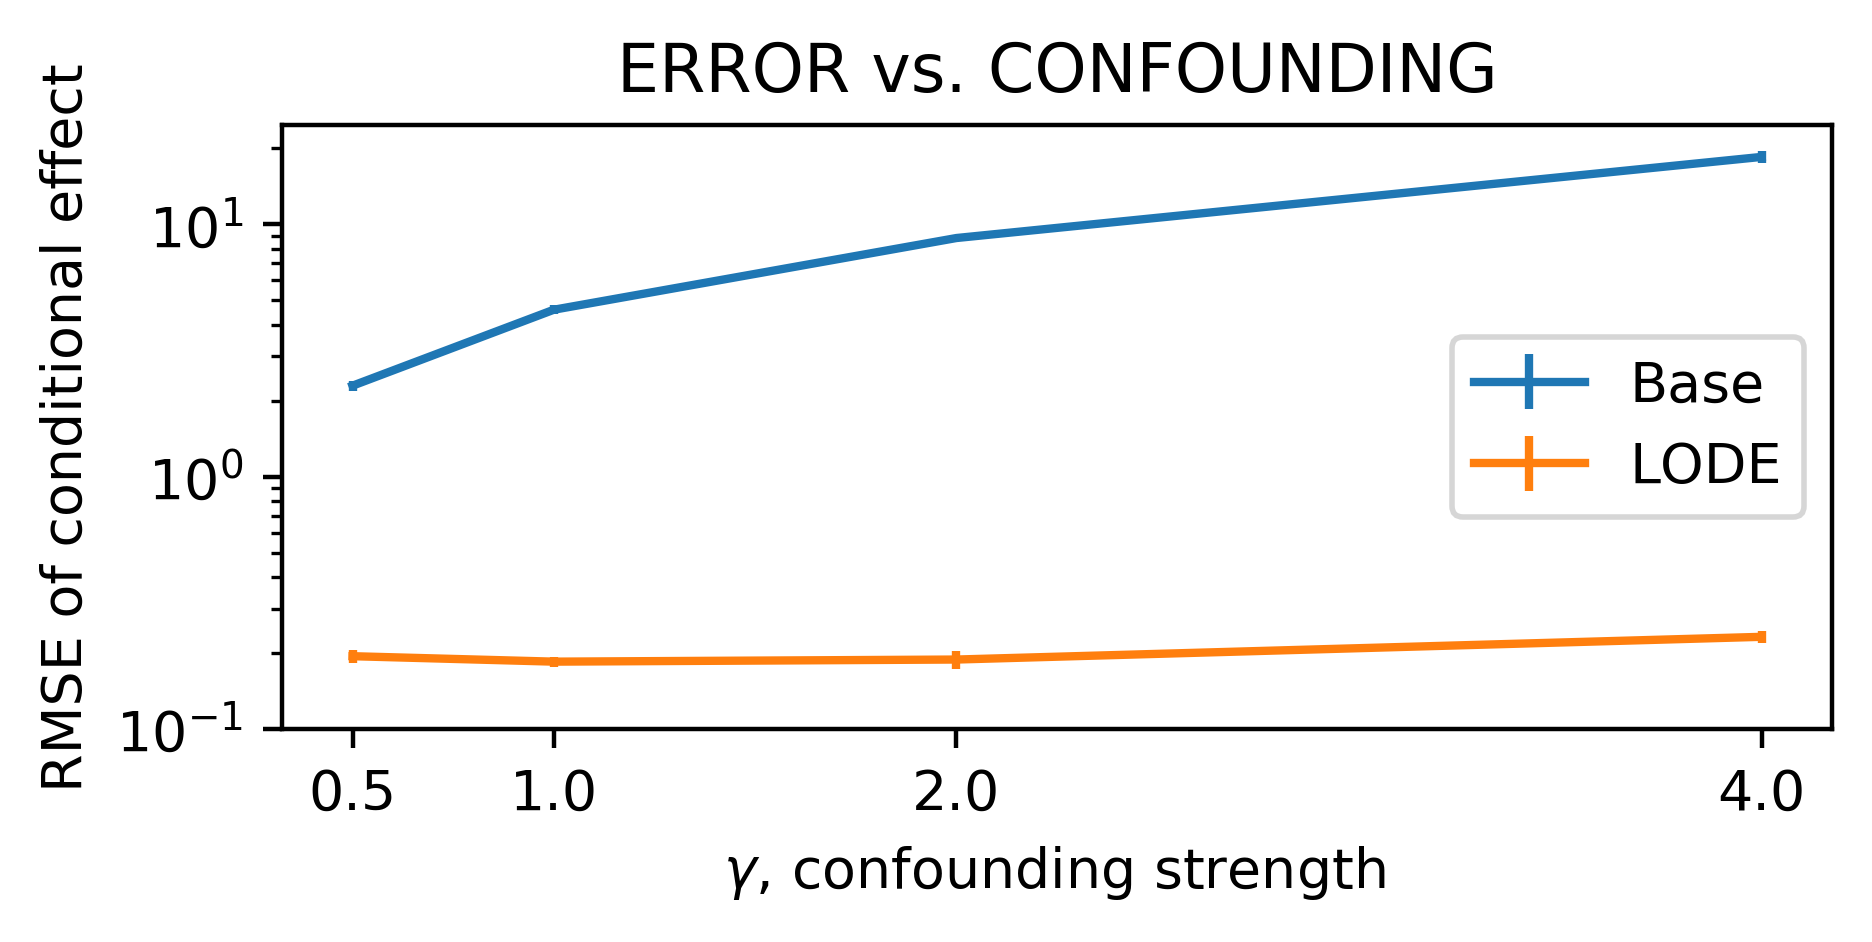

In [8]:
err_dict_numt = np.load(effectest_filename, allow_pickle=True)[()]
print(effectest_filename)
gamma_list = main_gamma_list

for numt in numt_list:

    base_mean_err = []
    lode_mean_err = []

    base_std_err = []
    lode_std_err = []
    
    for gamma in gamma_list:
    #     print(err_dict_numt[numt][gamma])
        val = err_dict_numt[numt][gamma]
        key = numt
    #     for (key, val) in err_dict_numt[numt][gamma].items():
        print(key, np.mean(val['lode']), np.std(val['lode']))
        print(key, np.mean(val['base']), np.std(val['base']))

        base_mean_err.append(np.mean(val['base']))
        lode_mean_err.append(np.mean(val['lode']))

        base_std_err.append(np.std(val['base']))
        lode_std_err.append(np.std(val['lode']))

    fig, ax = plt.subplots(1,1, dpi=400, figsize=(5,2))
    
    plt.errorbar(gamma_list, base_mean_err, yerr=1.96*np.array(base_std_err), label='Base')
    plt.errorbar(gamma_list, lode_mean_err, yerr=1.96*np.array(lode_std_err), label='LODE')
#     ax = plt.axes()

    plt.xlabel(r'$\gamma$, confounding strength ')
    plt.ylabel('RMSE of conditional effect')
    plt.legend()
    plt.title('ERROR vs. CONFOUNDING')
    plt.xticks(gamma_list)
    plt.yscale('log')

    ax.set_yticks([0.1, 1, 10])

    plt.show()

# SURROGATE POSITIVITY EXPERIMENT

In [16]:
numt_list = [20]

err_dict_full_surr = {} 

corrupt_list = [0.0]
alpha_list = [1]# , 2, 5, 10] #[0.1, 1, 5]
gamma_list = main_gamma_list
tol_list = [1]
mu_list = [0.001, 0.1, 10.0]


torch.manual_seed(1000)
np.random.seed(1000)

kwargs = {
    'numt': numt_list[0],
    'gamma': gamma_list[0],
    'alpha': alpha_list[0],
    'corrupt': 0.0,
    't_tol' : 1e-4,
    'mu' : 1,
    'm' : m_train
}




for mu in mu_list:
    kwargs['mu'] = mu

    for gamma in gamma_list:
        kwargs['gamma'] = gamma

        config_name = "T{numt}_a{alpha}_g{gamma}_c{corrupt}_tol{t_tol}_mu{mu}".format(**kwargs)

        err_dict_full_surr[config_name] = {
            'lode':[],
            'base':[]
        }

        data_kwargs = {item:val for item, val in kwargs.items() if 't_tol'!= item}

        for seed in range(3):
            lode_rmse, baseline_rmse = run_LODE_with_args(generate_data, kwargs)
            
            err_dict_full_surr[config_name]['lode'].append(lode_rmse)
            err_dict_full_surr[config_name]['base'].append(baseline_rmse)

            print(" {}, base rmse = {}, lode rmse = {}".format(config_name, baseline_rmse, lode_rmse))

                    
np.save(surrpos_filename, err_dict_full_surr)
        
        

 train y_model loss =  0.3206023604922834
 exact y_model loss =  0.029643185473392265
 ---- USING t_tol =  0.0001
using LR=1
 -- iter 0, loss = 5.0094895362854
DONE optimizing at 691 with loss = 0.00026
 T20_a1_g0.5_c0.0_tol0.0001_mu0.001, base rmse = 28.24386948314499, lode rmse = 28.398663054632433
 train y_model loss =  0.3361483644870286
 exact y_model loss =  0.00029171529695694217
 ---- USING t_tol =  0.0001
using LR=1
 -- iter 0, loss = 5.155294418334961
DONE optimizing at 692 with loss = 0.00026
 T20_a1_g0.5_c0.0_tol0.0001_mu0.001, base rmse = 2.107498110103987, lode rmse = 2.1074981159424415
 train y_model loss =  0.32706931470988443
 exact y_model loss =  0.003964438366293612
 ---- USING t_tol =  0.0001
using LR=1
 -- iter 0, loss = 5.452786445617676
DONE optimizing at 734 with loss = 0.00026
 T20_a1_g0.5_c0.0_tol0.0001_mu0.001, base rmse = 2.1683830263021506, lode rmse = 2.168383006306689
 train y_model loss =  0.3253325219953896
 exact y_model loss =  0.009281810329758751
 

KeyboardInterrupt: 

In [ ]:

        
## PLOTTING
        
# corruption plot
err_dict_full_surr = np.load(surrpos_filename, allow_pickle=True)[()]

gamma_list = main_gamma_list
# tol_list = [1e-1, 1e-2]

kwargs = {
    'numt': numt_list[0],
    'gamma': gamma_list[0],
    'alpha': alpha_list[0],
    'corrupt': 0.0,
    't_tol' : 1e-4,
    'mu' : 1,
    'm' : 1000
}

t_tol = kwargs['t_tol']


plt.figure(dpi=300, figsize=(5,2))

def mean_std(arr_arr):
    return [np.mean(arr) for arr in arr_arr], [np.std(arr) for arr in arr_arr]


for mu in [0.001, 0.1, 10.0]:
    kwargs['mu'] = mu
    arr_list = []
    for gamma in gamma_list:
        kwargs['gamma'] = gamma
        
        config_name = "T{numt}_a{alpha}_g{gamma}_c{corrupt}_tol{t_tol}_mu{mu}".format(**kwargs)

        arr_list.append(err_dict_full_surr[config_name]['lode'])
#     print(arr_list)
    mean,std = mean_std(arr_list)
    print(mean)
    print('std', std)
#     plt.errorbar(corrupt_list, mean, yerr=std, label=r'$\gamma$ = {}'.format(gamma))
    plt.errorbar(gamma_list, mean, yerr=std, label=r'$\sigma$ = {}'.format(mu))
    
plt.legend(loc='best', ncol=3)
plt.xlabel(r'$\gamma$, strength of confounder')
# plt.legend()
# plt.xlabel(r'$\nu$, degree of orthogonality violation')
ax= plt.axes()
plt.xticks(gamma_list)
plt.yscale('log')
ax.set_yticks([0.01, 1e-1, 1, 10, 100, 200])
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


plt.ylabel('RMSE of conditional effect')
plt.title(' Effect Estimation and Surrogate Positivity')
plt.show()

# RMSE VS. LEARNING RATE EXPERIMENT

In [ ]:


numt_list = [20]

err_dict_full_lr = {} #np.load('err_dict_corruption_numt20_full.npy', allow_pickle=True)[()]
m_train = 1000
m_val = 1000
m_test = m_val

corrupt_list = [0.0] #, 0.1, 0.2, 0.3, 0.4]
alpha_list = [1] #[0.1, 1, 5]
gamma_list = main_gamma_list
tol_list = [1e-4]# [1, 1e-1, 1e-2]
lr_list = [0.5, 1, 2]

torch.manual_seed(1000)
np.random.seed(1000)

kwargs = {
    'numt': numt_list[0],
    'gamma': 1,
    'alpha': 1,
    'corrupt': 0.0,
    'm': m_train,
    'lr':1,
    't_tol' : 1e-4
}



for corrupt in corrupt_list:
    kwargs['corrupt'] = corrupt
    
    for gamma in gamma_list:
        kwargs['gamma'] = gamma
        
        for alpha in alpha_list:
            kwargs['alpha'] = alpha

            for lr in lr_list:
                kwargs['lr'] = lr
                
                config_name = "T{numt}_a{alpha}_g{gamma}_c{corrupt}_lr{lr}".format(**kwargs)
                
                err_dict_full_lr[config_name] = {
                    'lode':[],
                    'base':[]
                }
                
                for seed in range(3):
                
                    lode_rmse, baseline_rmse = run_LODE_with_args(generate_data, kwargs)
                    err_dict_full_lr[config_name]['lode'].append(lode_rmse)
                    err_dict_full_lr[config_name]['base'].append(baseline_rmse)

                    print(" {}, base rmse = {}, lode rmse = {}".format(config_name, baseline_rmse, lode_rmse))

                    
np.save(largelr__filename, err_dict_full_lr)

In [ ]:

err_dict_full_lr = np.load(largelr__filename, allow_pickle=True)[()]


corrupt_list = [0.0]
alpha_list = [1]
gamma_list = main_gamma_list
tol_list = [1e-4]
lr_list = [0.5, 1, 2]


kwargs = {
    'numt': numt_list[0],
    'gamma': 1,
    'alpha': 1,
    'corrupt': 0.0,
    'm': 1000,
    'lr':1,
    't_tol' : 1e-4
}


plt.figure(dpi=300, figsize=(4,2))

for lr in lr_list:
    kwargs['lr'] = lr
    arr_list = []
    for gamma in gamma_list:
        kwargs['gamma'] = gamma

        config_name = "T{numt}_a{alpha}_g{gamma}_c{corrupt}_lr{lr}".format(**kwargs)
        filtered_arr = np.array(err_dict_full_lr[config_name]['lode']).ravel()
        max_filter = 0.7  # REMOVE THIS WHEN THE 
        if np.max(filtered_arr) >= max_filter :
            filtered_arr[filtered_arr>=max_filter ] = np.mean(filtered_arr[filtered_arr<max_filter])
            print('FILTERED OUT', (filtered_arr>=max_filter).sum())
        print(lr)
        arr_list.append(filtered_arr)
    mean,std = mean_std(arr_list)
    print(mean)
    plt.errorbar(gamma_list, mean, yerr=std, label=r'$\ell$ = {}'.format(lr))
    
plt.legend()
plt.xlabel(r'$\gamma$, strength of confounding')
plt.xticks(gamma_list)
ax= plt.axes()
ax.get_yaxis().get_major_formatter().labelOnlyBase = False
plt.yscale('log')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Effect RMSE')
plt.title(' Effect Estimation vs. Learning rate')
plt.show()

# CONFOUNDER MISMATCH EXPERIMENT

In [ ]:
numt_list = [20]

err_dict_full_confounder_mismatch = {} #np.load('err_dict_corruption_numt20_full.npy', allow_pickle=True)[()]
m_train = 1000
m_val = 1000
m_test = m_val

corrupt_list = [0.0]
alpha_list = [0.5, 1, 2, 4]
gamma_list = [1]
tol_list = [1, 1e-1, 1e-2, 1e-4]


torch.manual_seed(1000)
np.random.seed(1000)

kwargs = {
    'numt': numt_list[0],
    'gamma': 1,
    'alpha': 1,
    'corrupt': 0.0,
    'm': m_train,
    't_tol' : 1e-4
}



for corrupt in corrupt_list:
    kwargs['corrupt'] = corrupt
    
    for gamma in gamma_list:
        kwargs['gamma'] = gamma
        
        for alpha in alpha_list:
            kwargs['alpha'] = alpha

            for tol in tol_list:
                kwargs['t_tol'] = tol
                
                config_name = "T{numt}_a{alpha}_g{gamma}_c{corrupt}_tol{t_tol}".format(**kwargs)
                
                err_dict_full_confounder_mismatch[config_name] = {
                    'lode':[],
                    'base':[]
                }
                
                # generate_data = utils_data.generate_nonlin_sqrd_data
                for seed in range(3):
                
                    lode_rmse, baseline_rmse = run_LODE_with_args(generate_data, kwargs)

                    err_dict_full_confounder_mismatch[config_name]['lode'].append(lode_rmse)
                    err_dict_full_confounder_mismatch[config_name]['base'].append(baseline_rmse)

                    print(" {}, base rmse = {}, lode rmse = {}".format(config_name, baseline_rmse, lode_rmse))

                    
np.save(confmismatch_filename, err_dict_full_confounder_mismatch)

In [ ]:
# corruption plot
# err_dict_full_alpha = 
kwargs['corrupt'] = 0.0
kwargs['gamma'] = 1

gamma_list = [1]

err_dict_full_confounder_mismatch = np.load(confmismatch_filename, allow_pickle=True)[()]
plt.figure(dpi=300, figsize=(5,2))

def mean_std(arr_arr):
    return [np.mean(arr) for arr in arr_arr], [np.std(arr) for arr in arr_arr]

for alpha in alpha_list:
    kwargs['alpha'] = alpha
    arr_list = []
    for t_tol in tol_list:
        kwargs['t_tol'] = t_tol

        config_name = "T{numt}_a{alpha}_g{gamma}_c{corrupt}_tol{t_tol}".format(**kwargs)

        arr_list.append(err_dict_full_confounder_mismatch[config_name]['lode'])
    mean,std = mean_std(arr_list)
    print(mean)
    plt.errorbar(tol_list, mean, yerr=std, label=r'$\alpha$ = {}'.format(alpha))
    
plt.legend()
plt.xlabel(r'$\delta$, confounder mismatch')
plt.xticks(tol_list)
plt.yticks(np.arange(0,13, 2))
plt.xscale('log')
plt.ylabel('Effect RMSE')
plt.title(' Effect Estimation under Confounder Mismatch')
plt.show()